In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import plotly.express as px


palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(8000)

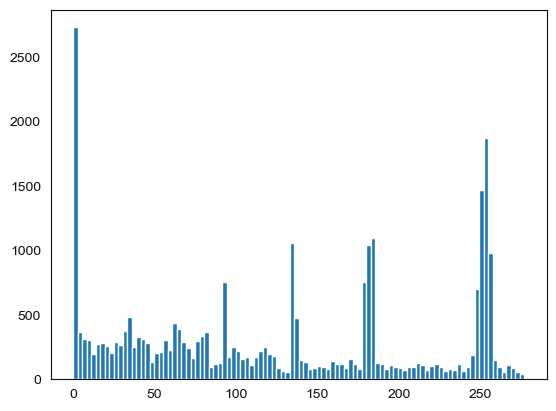

100%|██████████| 278/278 [00:07<00:00, 38.08it/s] 


In [15]:
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon")
spots_path = source_path / "out"
spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
spots_df.set_index("ID", inplace=True)
save_path = spots_path

plt.hist(spots_df.groupby("tracklet_id")["FRAME"].min(), bins=100)
plt.show()

cycle_starts = np.array([0, 30, 60, 110, 160, 280])
cycle_starts = np.array([0, 80, 110, 160, 210, 280])

um_per_px = 0.525
spots_df["x"] = spots_df["POSITION_X"] * um_per_px
spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
spots_df["y"] = spots_df["POSITION_Y"] * um_per_px

pos = np.array(spots_df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep
transformed_data = pca.fit_transform(pos)
spots_df["AP"] = transformed_data[:, 0]
spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
# fig, axes = plt.subplots(1, 3, figsize=(6, 2))
# for i in range(3):
#     axes[i].plot(pos[:, i], transformed_data[:, 0])
# plt.show()

spots_df["reflection_z"] = 2.1*spots_df["z"].max() - spots_df["z"]
spots_df["reflection_x"] = spots_df["x"].max() - spots_df["x"]

spots_df["is_reflected"] = spots_df["x"] > spots_df["x"].max() / 2

spots_df["display_x"] = spots_df["reflection_x"]*spots_df["is_reflected"] + spots_df["x"]*(~spots_df["is_reflected"])
spots_df["display_z"] = spots_df["reflection_z"]*spots_df["is_reflected"] + spots_df["z"]*(~spots_df["is_reflected"])

spots_df["approx_time"] = spots_df["FRAME"] * (22/60)

t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]

best_spots["local_density"] = 0
neighborhood_um = 30

for frame in tqdm(best_spots["FRAME"].unique()):
    frame_spots = best_spots[best_spots["FRAME"] == frame]
    coords = frame_spots[["x", "y", "z"]].values
    dists = cdist(coords, coords)
    close = dists < neighborhood_um
    local_density = close.sum(axis=1)
    best_spots.loc[frame_spots.index, "local_density"] = local_density
    
best_spots.to_csv(spots_path / "best_spots.csv")


In [16]:
def cycle_classifier(time):
    return np.argmax(cycle_starts > time)

tracklets = best_spots.groupby("tracklet_id")
tdf = dict()
tdf["cycle"] =  tracklets["FRAME"].min().apply(cycle_classifier)
tdf["track_id"] = tracklets["track_id"].first()
tdf["time_start"] = tracklets["approx_time"].min()
tdf["time_end"] = tracklets["approx_time"].max()
tdf["cycle_length"] = tdf["time_end"] - tdf["time_start"]
tdf["frame_start"] = tracklets["FRAME"].min()
tdf["frame_end"] = tracklets["FRAME"].max()
tdf["frame_half"] = np.round((tdf["frame_end"] + tdf["frame_start"]) / 2).astype(int)
tdf["x_start"] = tracklets["x"].first()
tdf["y_start"] = tracklets["y"].first()
tdf["z_start"] = tracklets["z"].first()
tdf["AP_start"] = tracklets["AP"].first()
tdf["theta_start"] = tracklets["theta"].first()
tdf["x_end"] = tracklets["x"].last()
tdf["y_end"] = tracklets["y"].last()
tdf["z_end"] = tracklets["z"].last()
tdf["AP_end"] = tracklets["AP"].last()
tdf["theta_end"] = tracklets["theta"].last()
tdf["start_density"] = tracklets["local_density"].first()
tdf["end_density"] = tracklets["local_density"].last()
tdf["median_density"] = tracklets["local_density"].median()
tdf["parent_tracklet"] = tracklets["parent_id"].first().map(best_spots["tracklet_id"]).fillna(0).astype(int)

tracklets = pd.DataFrame(tdf)
tracklets["track_n_tracklets"] = tracklets["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
tracklets["track_n_tracklets"].value_counts()

spot_pivot = best_spots.pivot_table(index="tracklet_id", columns="FRAME", values="local_density", fill_value=0)
tracklets["half_density"] = [spot_pivot.loc[tracklet_id, frame] for tracklet_id, frame in zip(tracklets.index, tracklets["frame_half"])]
# print(list(tracklets.iloc[i] for i in np.argwhere(tracklets["half_density"].isna())[:, 0]))

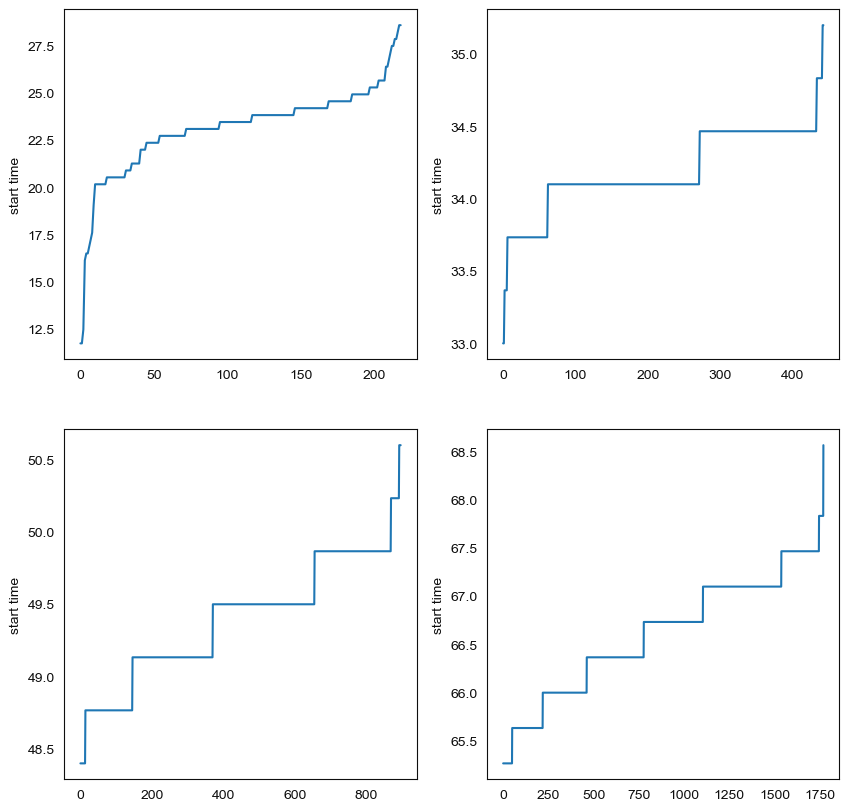

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 28]
    start_mean = t["time_start"].mean()
    start_std = t["time_start"].std()
    k = 3
    # print(start_mean - k*start_std, start_mean + k*start_std)
    t = t[t["time_start"].between(start_mean - k*start_std, start_mean + k*start_std)]
    # sns.histplot(t, x="time_start", ax=ax)
    ax.plot(sorted(t["time_start"]))
    ax.set_ylabel("start time")

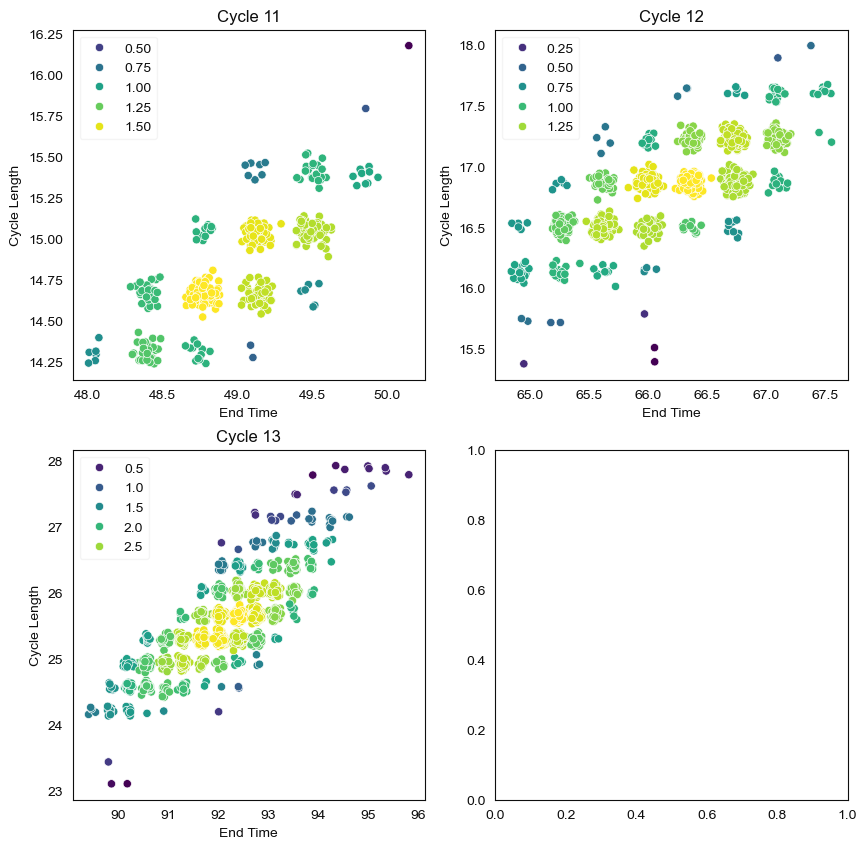

In [19]:
from scipy.stats import gaussian_kde

def jitter(x, factor=0.05):
    return x + factor*np.random.randn(len(x))

def measure_density(x, y):
    rescaled_x = (x - x.min()) / (x.max() - x.min())
    rescaled_y = (y - y.min()) / (y.max() - y.min())
    xy = np.vstack([rescaled_x, rescaled_y])
    kde = gaussian_kde(xy, bw_method=2)
    return kde(xy)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = "time_end"
y = "cycle_length"
k = 3

for cycle, ax in zip([2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 28]
    
    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k*factor_std, factor_mean + k*factor_std)]
        

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    ax.set_xlabel("End Time")
    ax.set_ylabel("Cycle Length")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "cycle_length_vs_time.png", dpi=300)
plt.show()

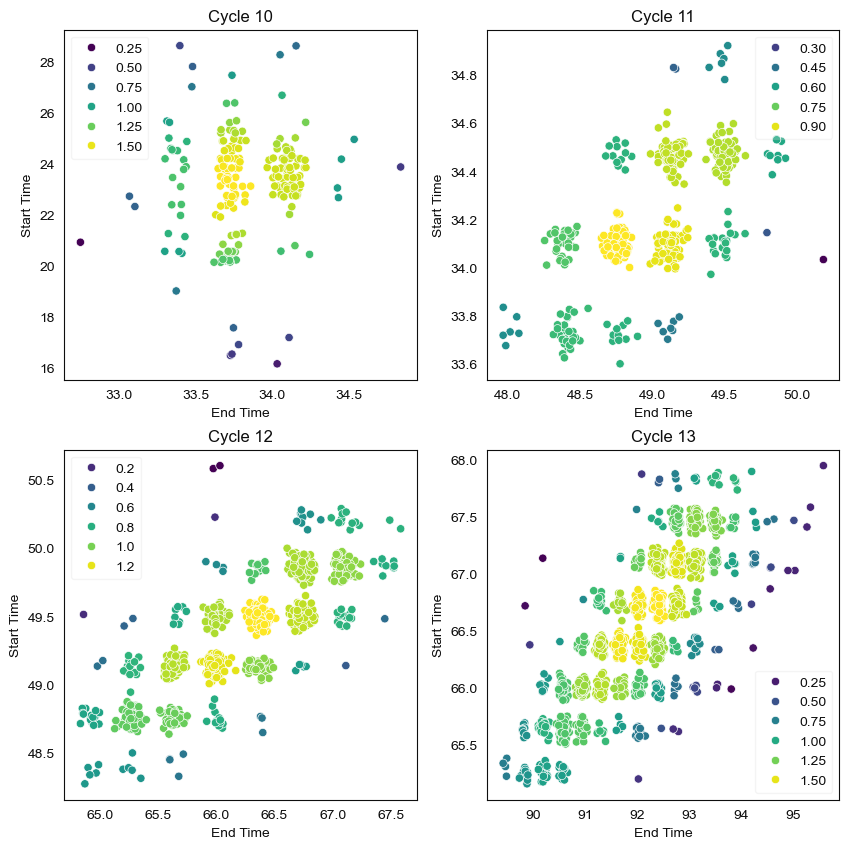

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = "time_end"
y = "time_start"
k = 3

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 28]
    
    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k*factor_std, factor_mean + k*factor_std)]
        

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    ax.set_xlabel("End Time")
    ax.set_ylabel("Start Time")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "cycle_end_vs_cycle_start.png", dpi=300)
plt.show()

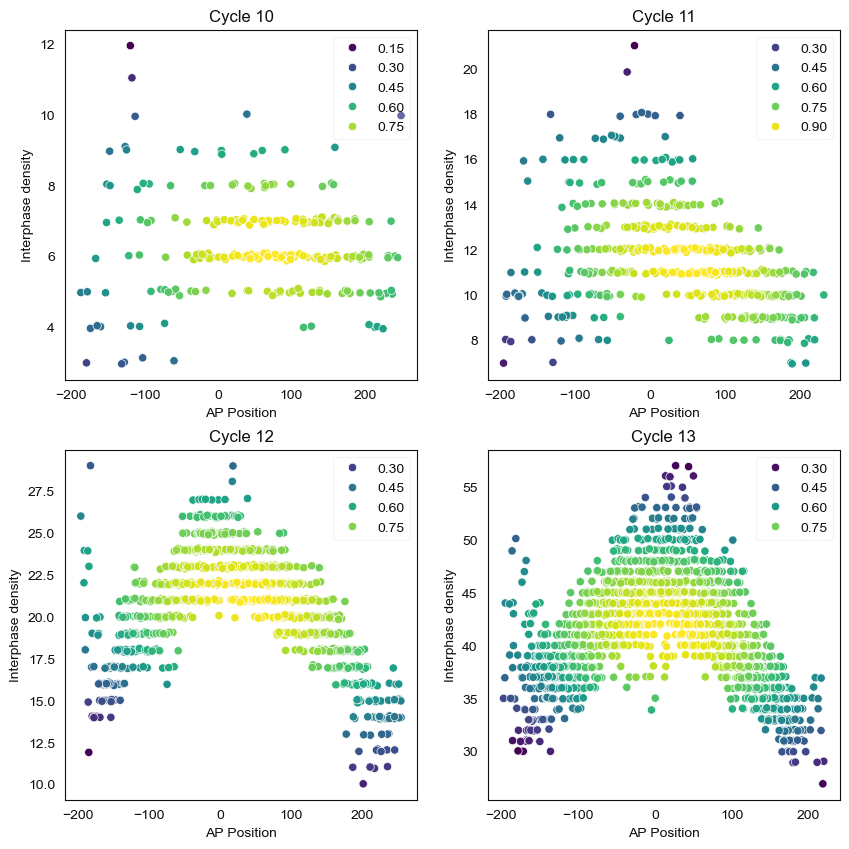

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = "AP_end"
y = "half_density"
k = 1.5

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 14]
    
    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k*factor_std, factor_mean + k*factor_std)]
        

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    x_binned = [(a.right + a.left)/2 for a in pd.cut(t[x], bins=25)]
    # sns.lineplot(x=x_binned, y=t[y], ax=ax, color="black")
    ax.set_xlabel("AP Position")
    ax.set_ylabel("Interphase density")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "AP_position_vs_interphase_density.png", dpi=300)

plt.show()

In [24]:
tracklets.columns

Index(['cycle', 'track_id', 'time_start', 'time_end', 'cycle_length',
       'frame_start', 'frame_end', 'frame_half', 'x_start', 'y_start',
       'z_start', 'AP_start', 'theta_start', 'x_end', 'y_end', 'z_end',
       'AP_end', 'theta_end', 'start_density', 'end_density', 'median_density',
       'track_n_tracklets', 'half_density'],
      dtype='object')

0.5532298297508316
0.42143286121785617


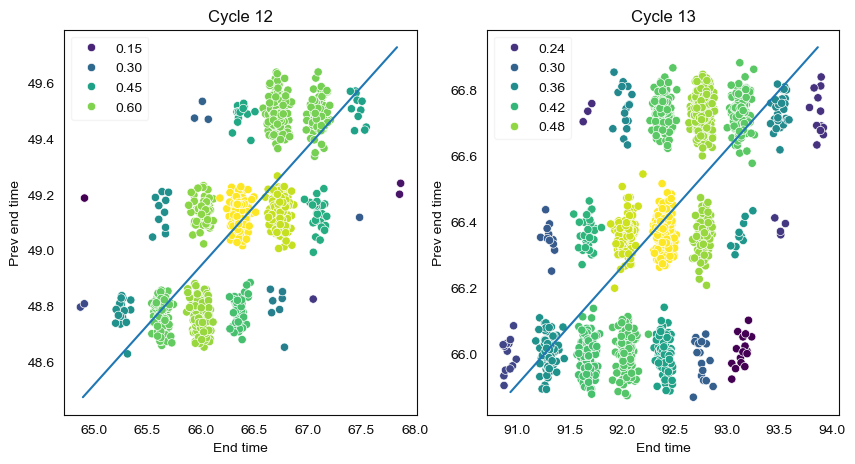

In [23]:
from sklearn import linear_model

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

x = "time_end"
y = "prev_end"
k = 1.5

for cycle, ax in zip([3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t_prev = tracklets[tracklets["cycle"] == cycle - 1]
    t = t[t["track_n_tracklets"] > 14]
    t = t[t["parent_tracklet"] != 0]
    
    t["prev_end"] = t["parent_tracklet"].map(t_prev["time_end"])
    
    for factor in ["time_end", "cycle_length", "time_start", "prev_end"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k*factor_std, factor_mean + k*factor_std)]
        

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    x_binned = [(a.right + a.left)/2 for a in pd.cut(t[x], bins=25)]
    
    x_ = np.reshape(t[x], (-1, 1))
    y_ = np.reshape(t[y], (-1, 1))
    
    reg_fit = linear_model.LinearRegression()
    reg_fit.fit(x_, y_)
    
    xrange = np.linspace(x_.min(), x_.max()).reshape(-1, 1)
    y_fit = reg_fit.predict(xrange)
    ax.plot(xrange, y_fit)
    
    r2 = reg_fit.score(x_, y_)
    print(r2)
    
    # sns.lineplot(x=x_binned, y=t[y], ax=ax, color="black")
    ax.set_xlabel("End time")
    ax.set_ylabel("Prev end time")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "parent_cycle_length.png", dpi=300)

plt.show()

0.028366162907992876
0.030854534141761647


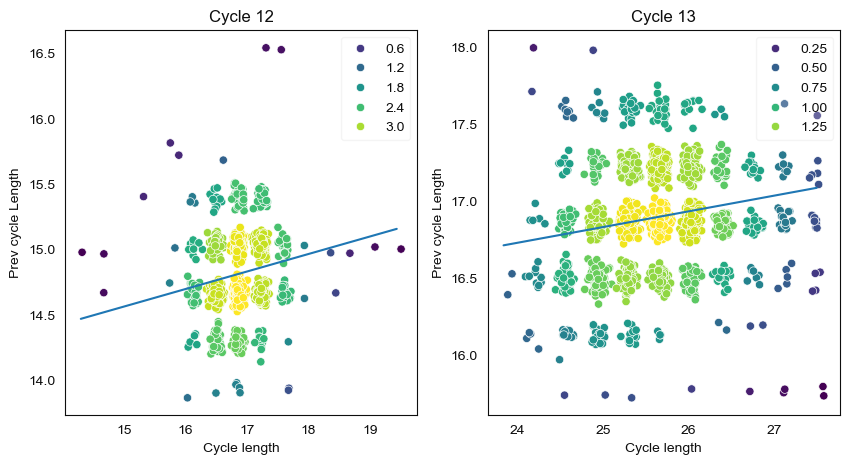

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

x = "cycle_length"
y = "prev_length"
k = 2

for cycle, ax in zip([3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t_prev = tracklets[tracklets["cycle"] == cycle - 1]
    t = t[t["track_n_tracklets"] > 14]
    t = t[t["parent_tracklet"] != 0]
    
    t["prev_length"] = t["parent_tracklet"].map(t_prev["cycle_length"])
    
    for factor in ["time_end", "cycle_length", "time_start", "prev_length"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k*factor_std, factor_mean + k*factor_std)]
        

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    x_binned = [(a.right + a.left)/2 for a in pd.cut(t[x], bins=25)]
    
    x_ = np.reshape(t[x], (-1, 1))
    y_ = np.reshape(t[y], (-1, 1))

    reg_fit = linear_model.LinearRegression()
    reg_fit.fit(x_, y_)

    xrange = np.linspace(x_.min(), x_.max()).reshape(-1, 1)
    y_fit = reg_fit.predict(xrange)
    ax.plot(xrange, y_fit)

    r2 = reg_fit.score(x_, y_)
    print(r2)

    
    # sns.lineplot(x=x_binned, y=t[y], ax=ax, color="black")
    ax.set_xlabel("Cycle length")
    ax.set_ylabel("Prev cycle Length")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "parent_cycle_length.png", dpi=300)

plt.show()

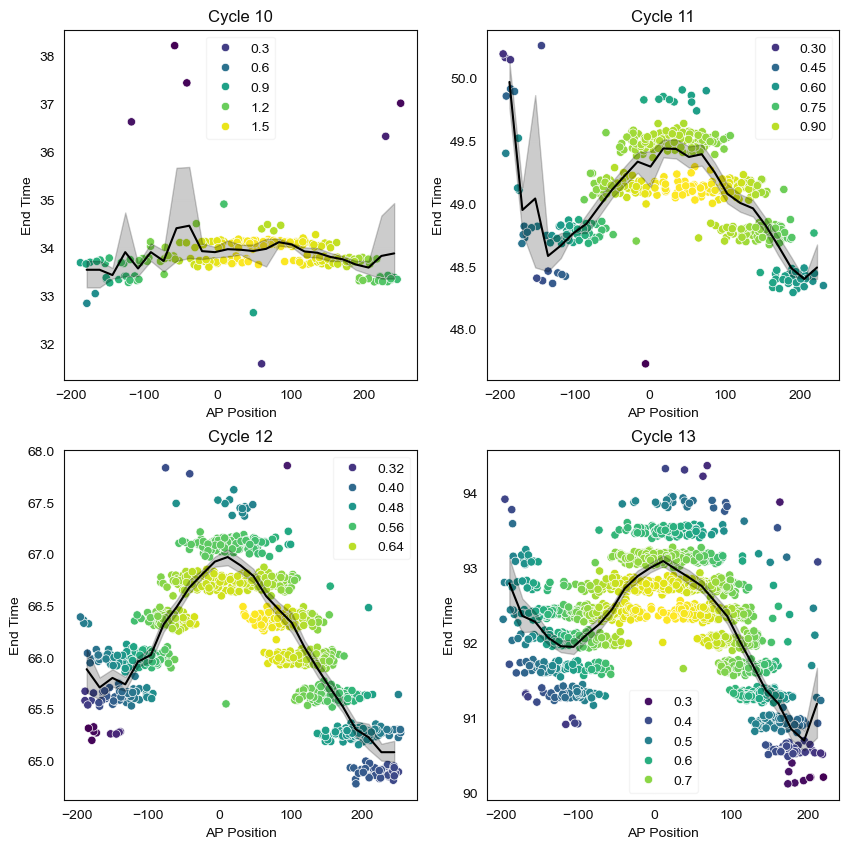

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = "AP_end"
y = "time_end"
k = 1.5

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 14]
    
    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k*factor_std, factor_mean + k*factor_std)]
        

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    x_binned = [(a.right + a.left)/2 for a in pd.cut(t[x], bins=25)]
    sns.lineplot(x=x_binned, y=t[y], ax=ax, color="black")
    ax.set_xlabel("AP Position")
    ax.set_ylabel("End Time")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "AP_position_vs_cycle_end.png", dpi=300)
plt.show()

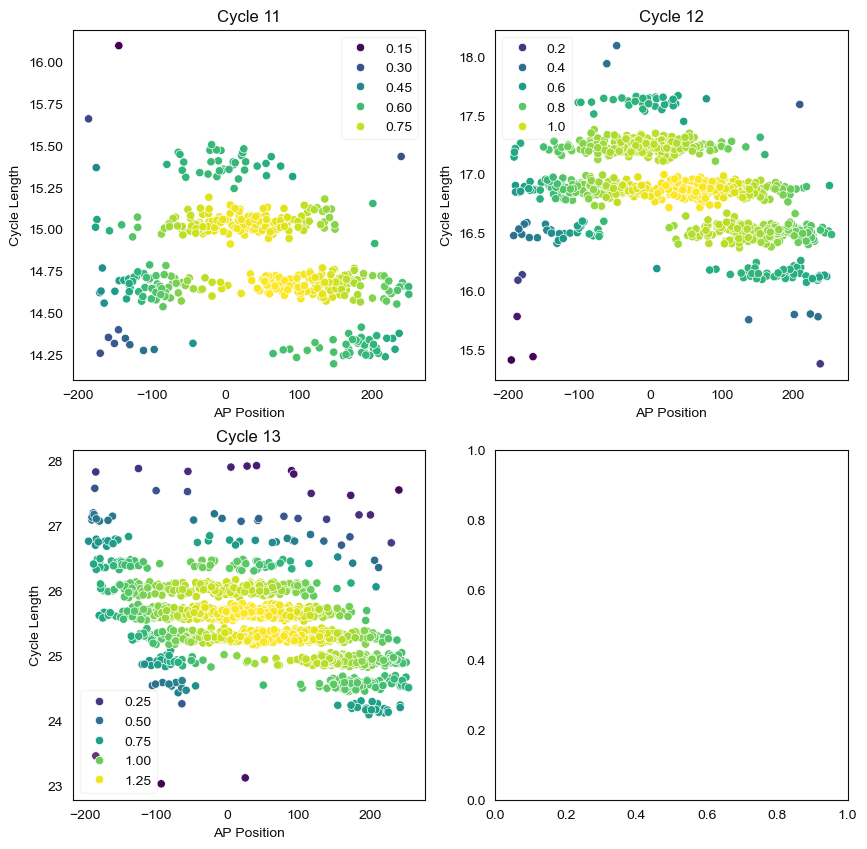

In [26]:
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = "AP_end"
y = "cycle_length"
k = 3

for cycle, ax in zip([2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 28]

    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k * factor_std, factor_mean + k * factor_std)]

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    ax.set_xlabel("AP Position")
    ax.set_ylabel("Cycle Length")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "AP_position_vs_cycle_length.png", dpi=300)
plt.show()

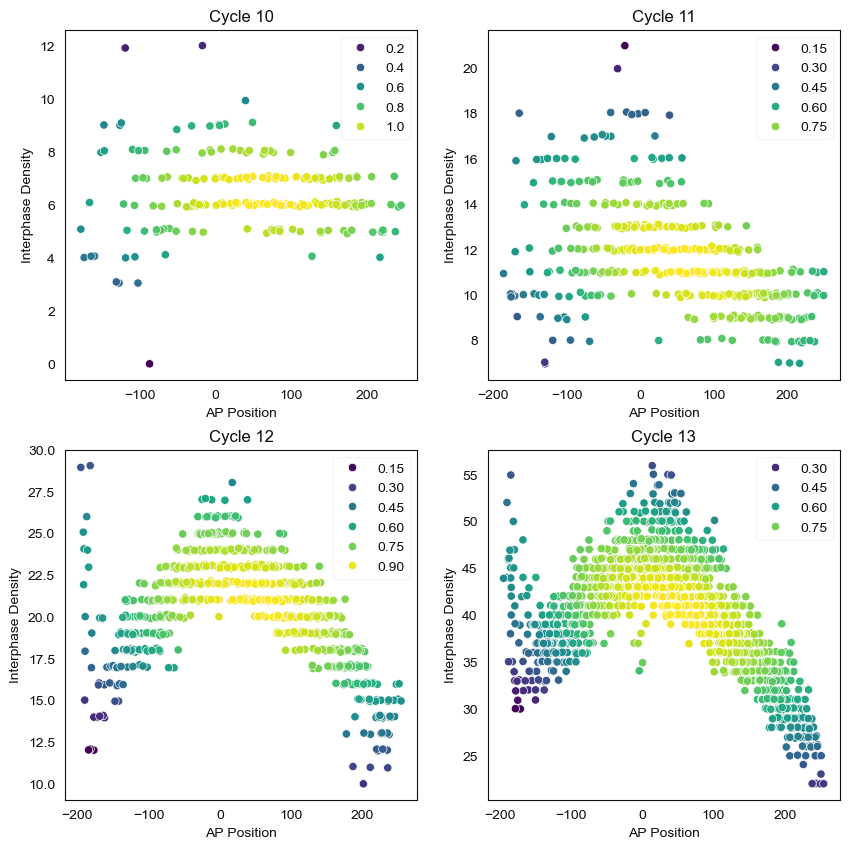

In [27]:
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = "AP_end"
y = "half_density"
k = 3

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 28]

    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k * factor_std, factor_mean + k * factor_std)]

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    ax.set_xlabel("AP Position")
    ax.set_ylabel("Interphase Density")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "AP_vs_interphase_density.png", dpi=300)
plt.show()

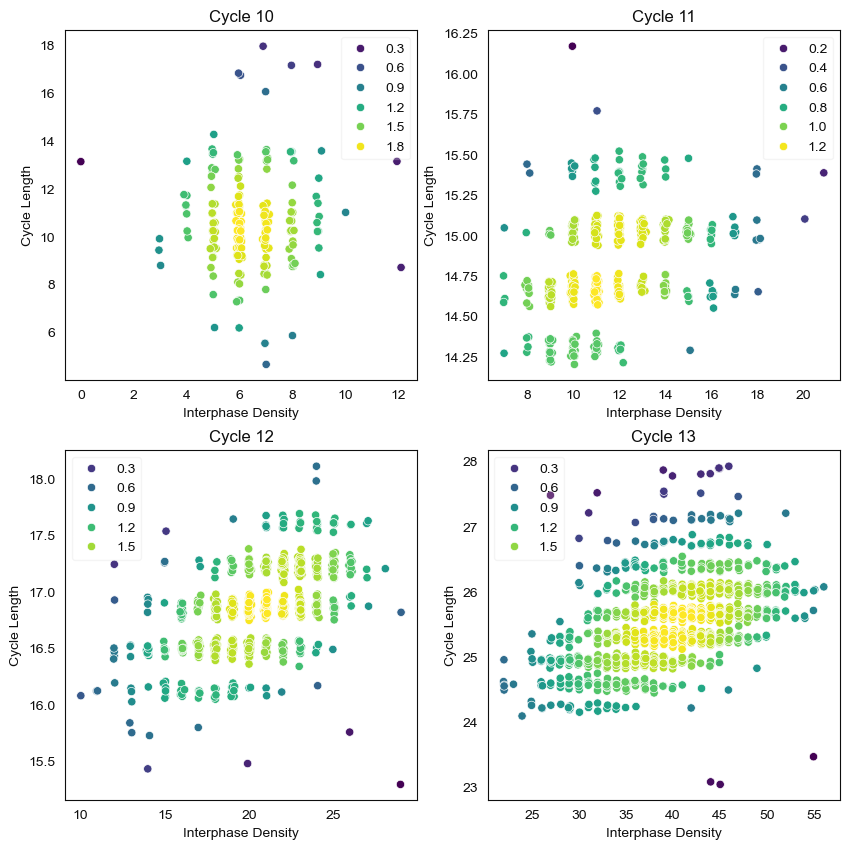

In [28]:
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = "half_density"
y = "cycle_length"
k = 3

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 28]

    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k * factor_std, factor_mean + k * factor_std)]

    density = measure_density(t[x], t[y])
    sns.scatterplot(t, x=jitter(t[x]), y=jitter(t[y]), hue=density, ax=ax, palette="viridis")
    ax.set_xlabel("Interphase Density")
    ax.set_ylabel("Cycle Length")
    ax.set_title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "interphase_density_vs_cycle_length.png", dpi=300)
plt.show()

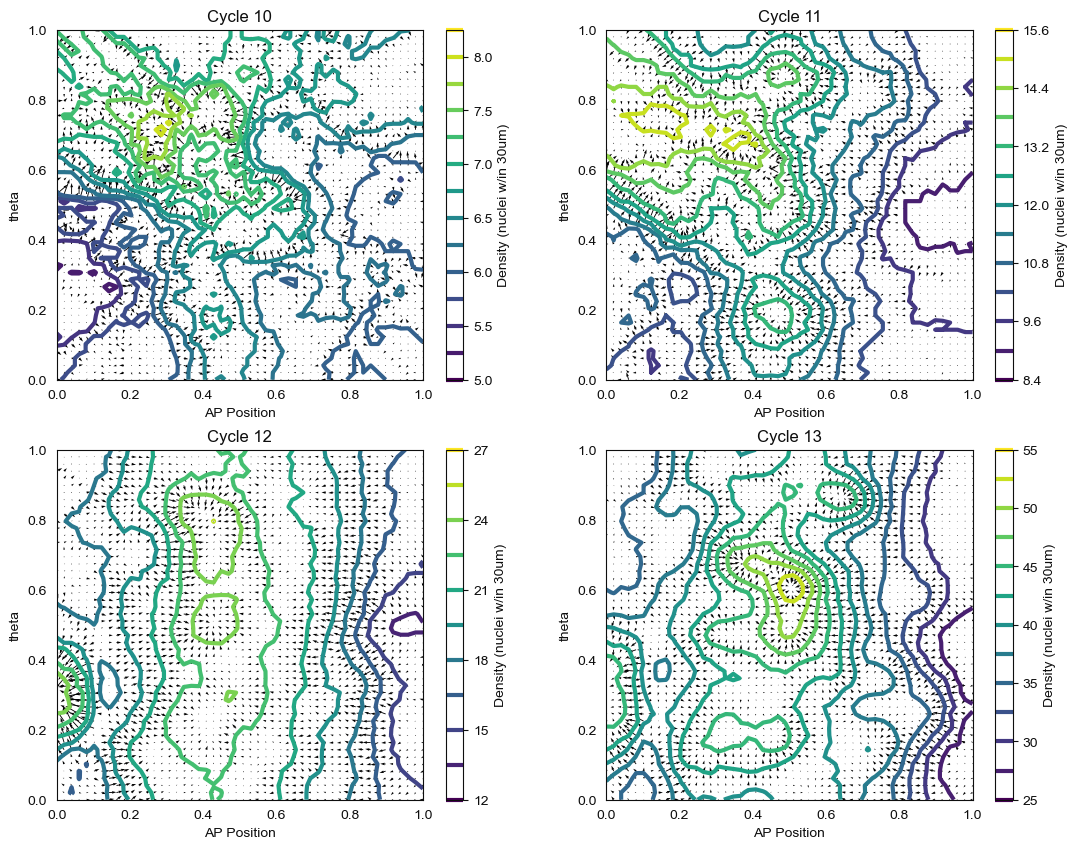

In [29]:
from sklearn.neighbors import NearestNeighbors

def get_contour(x, y, z, n=50):
    
    x = (x.copy()  - x.min())/ (x.max() - x.min())
    y = (y.copy()  - y.min())/ (y.max() - y.min())
    
    tester = NearestNeighbors()
    tester.fit(np.array([x, y]).T)
    
    
    x_bins = np.linspace(x.min(), x.max(), n)
    y_bins = np.linspace(y.min(), y.max(), n)
    X, Y = np.meshgrid(x_bins, y_bins)
    
    Z = np.zeros_like(X)
    for i, x_bin in enumerate(x_bins):
        for j, y_bin in enumerate(y_bins):
            # x_bin = (x_bin - x.min()) / (x.max() - x.min())
            # y_bin = (y_bin - y.min()) / (y.max() - y.min())
            _, indices = tester.kneighbors([[x_bin, y_bin]], 25)
            # print([z[idx] for idx in indices[0]])
            Z[j, i] = np.mean([z[idx] for idx in indices[0]])

    return X, Y, Z



fig, axes = plt.subplots(2, 2, figsize=(13, 10))

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 14]

    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k * factor_std, factor_mean + k * factor_std)]
        
    x = np.array(t["AP_end"])
    y = np.array(t["theta_end"])
    z = np.array(t["half_density"])
    
    X, Y, Z = get_contour(x, y, z, 50)
    
    dzdx = np.gradient(Z, axis=1)
    dzdy = np.gradient(Z, axis=0)
    
    plt.sca(ax)
    plt.contour(X, Y, Z, levels=11, cmap="viridis", linewidths=3)
    plt.colorbar(label="Density (nuclei w/in 30um)")
    plt.quiver(X, Y, dzdx, dzdy)
    plt.xlabel("AP Position")
    plt.ylabel("theta")
    plt.title(f"Cycle {cycle + 9}")

plt.savefig(save_path / "AP_vs_theta_vs_density.png", dpi=300)
plt.show()

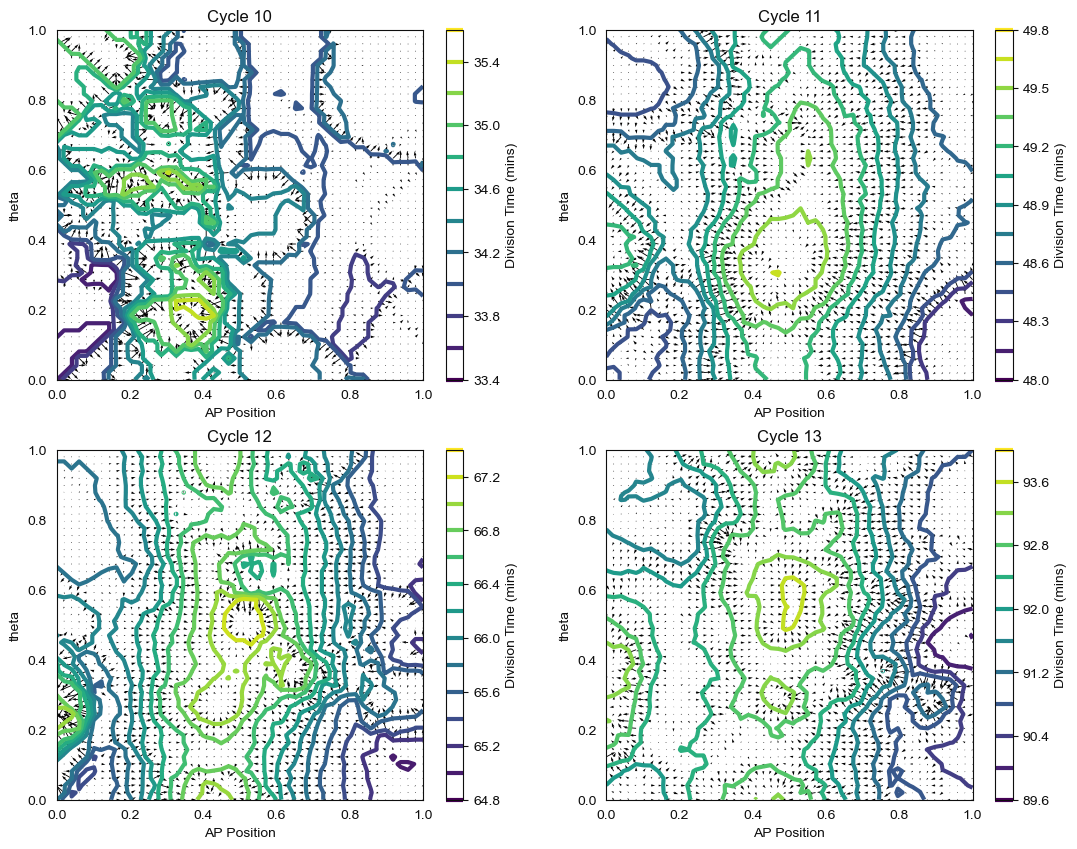

In [30]:
def get_contour(x, y, z, n=50):
    
    x = (x.copy()  - x.min())/ (x.max() - x.min())
    y = (y.copy()  - y.min())/ (y.max() - y.min())
    
    tester = NearestNeighbors()
    tester.fit(np.array([x, y]).T)
    
    
    x_bins = np.linspace(x.min(), x.max(), n)
    y_bins = np.linspace(y.min(), y.max(), n)
    X, Y = np.meshgrid(x_bins, y_bins)
    
    Z = np.zeros_like(X)
    for i, x_bin in enumerate(x_bins):
        for j, y_bin in enumerate(y_bins):
            # x_bin = (x_bin - x.min()) / (x.max() - x.min())
            # y_bin = (y_bin - y.min()) / (y.max() - y.min())
            _, indices = tester.kneighbors([[x_bin, y_bin]], 25)
            # print([z[idx] for idx in indices[0]])
            Z[j, i] = np.mean([z[idx] for idx in indices[0]])

    return X, Y, Z



fig, axes = plt.subplots(2, 2, figsize=(13, 10))

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 14]

    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k * factor_std, factor_mean + k * factor_std)]
        
    x = np.array(t["AP_end"])
    y = np.array(t["theta_end"])
    z = np.array(t["time_end"])
    
    X, Y, Z = get_contour(x, y, z, 50)
    
    dzdx = np.gradient(Z, axis=1)
    dzdy = np.gradient(Z, axis=0)
    
    plt.sca(ax)
    plt.contour(X, Y, Z, levels=11, cmap="viridis", linewidths=3)
    plt.colorbar(label="Division Time (mins)")
    plt.quiver(X, Y, dzdx, dzdy)
    plt.title(f"Cycle {cycle + 9}")
    plt.xlabel("AP Position")
    plt.ylabel("theta")

plt.savefig(save_path / "AP_vs_theta_vs_time.png", dpi=300)
plt.show()


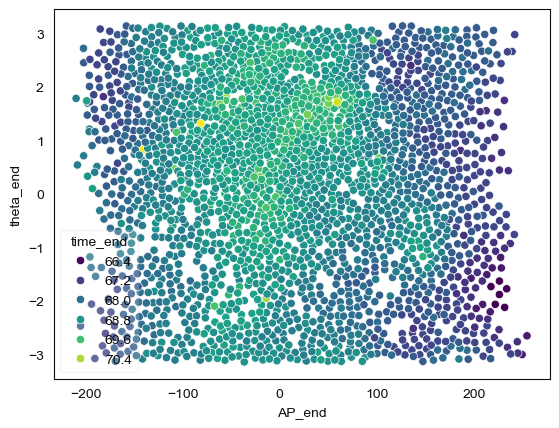

In [49]:
t = tracklets[tracklets["cycle"] == 4]
t = t[t["track_n_tracklets"] > 14]

for factor in ["time_end", "cycle_length", "time_start"]:
    factor_mean = t[factor].mean()
    factor_std = t[factor].std()
    # print(start_mean - k*start_std, start_mean + k*start_std)
    t = t[t[factor].between(factor_mean - k * factor_std, factor_mean + k * factor_std)]
sns.scatterplot(t, x="AP_end", y="theta_end", hue="time_end", palette="viridis")
plt.savefig(save_path / "good_segmented_nuclei.png", dpi=300)
plt.show()

C:\Users\Harrison\AppData\Local\Temp\ipykernel_11344\2756788082.py:28: RuntimeWarning: invalid value encountered in divide
  cos_sim = (dzdx_wave * dzdx_density + dzdy_wave * dzdy_density) / (np.sqrt(dzdx_wave**2 + dzdy_wave**2) * np.sqrt(dzdx_density**2 + dzdy_density**2))
C:\Users\Harrison\AppData\Local\Temp\ipykernel_11344\2756788082.py:28: RuntimeWarning: invalid value encountered in divide
  cos_sim = (dzdx_wave * dzdx_density + dzdy_wave * dzdy_density) / (np.sqrt(dzdx_wave**2 + dzdy_wave**2) * np.sqrt(dzdx_density**2 + dzdy_density**2))
C:\Users\Harrison\AppData\Local\Temp\ipykernel_11344\2756788082.py:28: RuntimeWarning: invalid value encountered in divide
  cos_sim = (dzdx_wave * dzdx_density + dzdy_wave * dzdy_density) / (np.sqrt(dzdx_wave**2 + dzdy_wave**2) * np.sqrt(dzdx_density**2 + dzdy_density**2))
C:\Users\Harrison\AppData\Local\Temp\ipykernel_11344\2756788082.py:28: RuntimeWarning: invalid value encountered in divide
  cos_sim = (dzdx_wave * dzdx_density + dzdy_wave * 

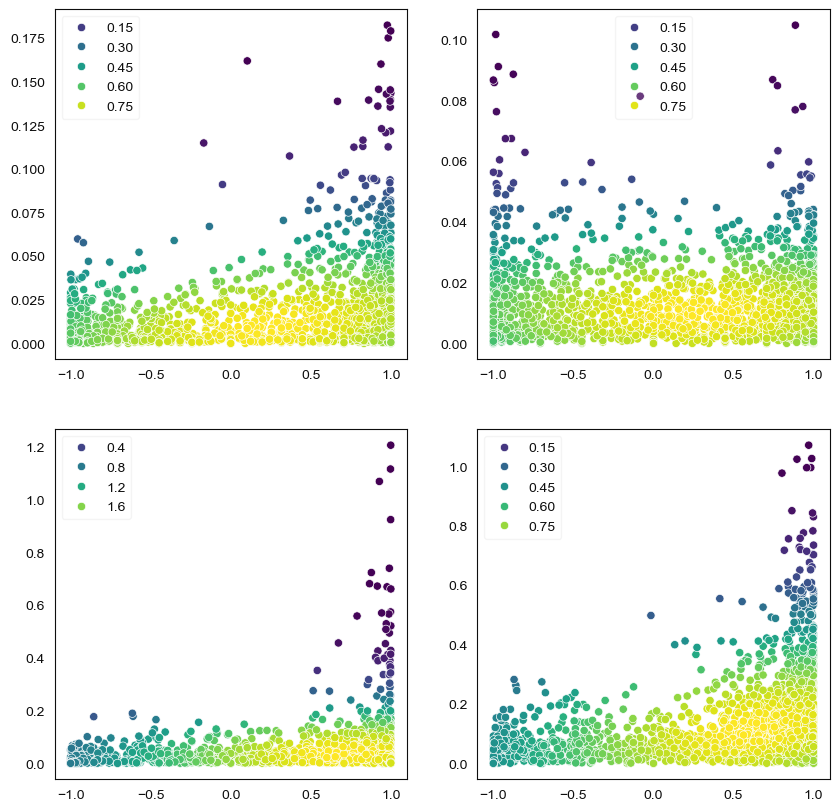

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for cycle, ax in zip([1, 2, 3, 4], axes.flatten()):
    t = tracklets[tracklets["cycle"] == cycle]
    t = t[t["track_n_tracklets"] > 14]

    for factor in ["time_end", "cycle_length", "time_start"]:
        factor_mean = t[factor].mean()
        factor_std = t[factor].std()
        # print(start_mean - k*start_std, start_mean + k*start_std)
        t = t[t[factor].between(factor_mean - k * factor_std, factor_mean + k * factor_std)]
        
    x = np.array(t["AP_end"])
    y = np.array(t["theta_end"])
    wave = np.array(t["time_end"])
    density = np.array(t["half_density"])
    
    X, Y, Z_wave = get_contour(x, y, wave, 50)
    X, Y, Z_density = get_contour(x, y, density, 50)
    
    # gradients
    dzdx_wave = np.gradient(Z_wave, axis=1)
    dzdy_wave = np.gradient(Z_wave, axis=0)
    dzdx_density = np.gradient(Z_density, axis=1)
    dzdy_density = np.gradient(Z_density, axis=0)
    
    # cosine similarity and magnitude
    cos_sim = (dzdx_wave * dzdx_density + dzdy_wave * dzdy_density) / (np.sqrt(dzdx_wave**2 + dzdy_wave**2) * np.sqrt(dzdx_density**2 + dzdy_density**2))
    magnitude = np.sqrt(dzdx_wave**2 + dzdy_wave**2) * np.sqrt(dzdx_density**2 + dzdy_density**2)
    
    x = np.nan_to_num(cos_sim.flatten(), nan=0)
    y = np.nan_to_num(magnitude.flatten(), nan=0)
    density = measure_density(x, y)
    
    plt.sca(ax)
    sns.scatterplot(x=x, y=y, hue=density, ax=ax, palette="viridis")
    
plt.show()

In [32]:


fig = px.scatter(best_spots, x="AP", y="theta", color="local_density", animation_frame="FRAME", range_color=[0, 50], color_continuous_scale="Viridis")
fig.update_layout(title="Local Density")
fig.update_xaxes(title="AP Position (um)")
fig.update_yaxes(title="theta (radians)")
fig.write_html(save_path / "local_density.html")

In [6]:
# best_spots = best_spots[best_spots["approx_time"] > 20].copy() 
# 
# d_x = best_spots["x"] - best_spots["parent_id"].map(best_spots["x"])
# d_y = best_spots["y"] - best_spots["parent_id"].map(best_spots["y"])
# d_z = best_spots["z"] - best_spots["parent_id"].map(best_spots["z"])
# 
# mag = np.sqrt(d_x**2 + d_y**2 + d_z**2)
# speed = mag / 3
# 
# best_spots["speed"] = speed
# 
# plt.figure(figsize=(6, 6))
# sns.histplot(speed[speed < 5], bins=50, color=palette["green"])
# plt.title("Speed distribution of nuclei")
# plt.xlabel("Speed (um/min)")
# plt.ylabel("Count")
# plt.savefig(save_path / "speed_distribution.png", dpi=300)
# plt.close()
# 
# plt.figure(figsize=(6, 6))
# sns.lineplot(best_spots, x="approx_time", y="speed", color=palette["green"])
# plt.title("Average speed of nuclei over time")
# plt.xlabel("Time (mins)")
# plt.ylabel("Mean Speed")
# plt.savefig(save_path / "speed_overtime.png", dpi=300)
# plt.close()
